In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, AccuracyTrackingCallBack, LossTrackingCallbackNew
from utils import print_model_structure, count_unique_values, count_unique_values_and_plot_histograms, count_unique_values_2

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

In [3]:
validation_data = (x_test, y_test)
num_epochs = 10
batch_size = 32

In [4]:
from datetime import datetime

log_dir = f'logs_cifar/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
os.makedirs(log_dir)

In [5]:
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D

input_layer = Input(shape=(32, 32, 3))  
conv_layer_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
pooling_layer_1 = MaxPooling2D(pool_size=(2, 2))(conv_layer_1)
conv_layer_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(pooling_layer_1)
pooling_layer_2 = MaxPooling2D(pool_size=(2, 2))(conv_layer_2)
flatten_layer = Flatten()(pooling_layer_2)  
dense_layer_1 = Dense(128, activation='relu')(flatten_layer) 
output_layer = Dense(10, activation='softmax')(dense_layer_1)

cifar_model = Model(inputs=input_layer, outputs=output_layer)

accuracy_callback = AccuracyTrackingCallBack(cifar_model.get_layer(index=7), log_dir, file_name="vanilla_accuracy.log")

cifar_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

cifar_model.fit(
    x_train, y_train, 
    epochs=num_epochs,  # Adjust the number of epochs as needed
    batch_size=batch_size,  # Adjust the batch size
    callbacks=[
        accuracy_callback
    ]
)

Epoch 1/10
1563/1563 [==============================] - 43s 27ms/step - loss: 2.0973 - accuracy: 0.4245
Epoch 2/10
1563/1563 [==============================] - 50s 32ms/step - loss: 1.2180 - accuracy: 0.5723
Epoch 3/10
1563/1563 [==============================] - 47s 30ms/step - loss: 1.0633 - accuracy: 0.6271
Epoch 4/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.9552 - accuracy: 0.6681
Epoch 5/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8559 - accuracy: 0.6999
Epoch 6/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.7626 - accuracy: 0.7328
Epoch 7/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.6919 - accuracy: 0.7580
Epoch 8/10
1563/1563 [==============================] - 49s 31ms/step - loss: 0.6121 - accuracy: 0.7860
Epoch 9/10
1563/1563 [==============================] - 43s 28ms/step - loss: 0.5512 - accuracy: 0.8086
Epoch 10/10
1563/1563 [==============================] - 43s 28m

In [6]:
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D

input_layer = Input(shape=(32, 32, 3))  
conv_layer_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
pooling_layer_1 = MaxPooling2D(pool_size=(2, 2))(conv_layer_1)
conv_layer_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(pooling_layer_1)
pooling_layer_2 = MaxPooling2D(pool_size=(2, 2))(conv_layer_2)
flatten_layer = Flatten()(pooling_layer_2)  
dense_layer_1 = RowWiseQuantized(128)(flatten_layer) 
dense_layer_2 = tf.keras.activations.relu(dense_layer_1)
output_layer = RowWiseQuantized(10)(dense_layer_2)
output_layer_2 = tf.keras.activations.softmax(output_layer)

cifar_model = Model(inputs=input_layer, outputs=output_layer_2)

penalty_rate = 0.1
learning_rate = 0.001

# Initialize your custom loss function
loss_function = SCCEMaxBin(
    layers=[
        cifar_model.get_layer(index=6),
        cifar_model.get_layer(index=8)
    ],
    penalty_rate=penalty_rate,
    row_wise=1,
    log_dir = log_dir  # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
               # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
)


cifar_model.compile(
    optimizer=Adam(learning_rate=learning_rate), 
    loss=loss_function.compute_total_loss,
    metrics=['accuracy'],
)

validation_data = (x_test, y_test)
val_interval = 75

# Initialize your callbacks
scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(cifar_model.get_layer(index=6), log_dir)
scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(cifar_model.get_layer(index=8), log_dir)
penalty_callback = LossTrackingCallbackNew(loss_function=loss_function, validation_data=validation_data, interval=val_interval, log_dir=log_dir)
accuracy_callback = AccuracyTrackingCallBack(cifar_model.get_layer(index=8), log_dir)

cifar_model.fit(
    x_train, y_train, 
    epochs=num_epochs,
    validation_data=validation_data,
    callbacks=[
        scale_tracking_callback_first_dense_layer,
        scale_tracking_callback_second_dense_layer,
        penalty_callback,
        accuracy_callback,
    ],
    batch_size=batch_size,
)

Epoch 1/10
1563/1563 [==============================] - 113s 72ms/step - loss: 2.6181 - accuracy: 0.5267 - val_loss: 2.6133 - val_accuracy: 0.5171
Epoch 2/10
1563/1563 [==============================] - 117s 75ms/step - loss: 1.8786 - accuracy: 0.6040 - val_loss: 1.8645 - val_accuracy: 0.6030
Epoch 3/10
1563/1563 [==============================] - 121s 78ms/step - loss: 1.6150 - accuracy: 0.6306 - val_loss: 1.6146 - val_accuracy: 0.6258
Epoch 4/10
1563/1563 [==============================] - 120s 77ms/step - loss: 1.4535 - accuracy: 0.6554 - val_loss: 1.4202 - val_accuracy: 0.6598
Epoch 5/10
1563/1563 [==============================] - 116s 74ms/step - loss: 1.3194 - accuracy: 0.6719 - val_loss: 1.4089 - val_accuracy: 0.6508
Epoch 6/10
1563/1563 [==============================] - 110s 70ms/step - loss: 1.3717 - accuracy: 0.6412 - val_loss: 1.3535 - val_accuracy: 0.6523
Epoch 7/10
1563/1563 [==============================] - 103s 66ms/step - loss: 1.2425 - accuracy: 0.6753 - val_loss: 1

In [7]:
# Evaluate
loss, accuracy = cifar_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

313/313 [==============================] - 2s 5ms/step - loss: 1.6555 - accuracy: 0.5305
Quantized Model Test Accuracy: 0.5304999947547913


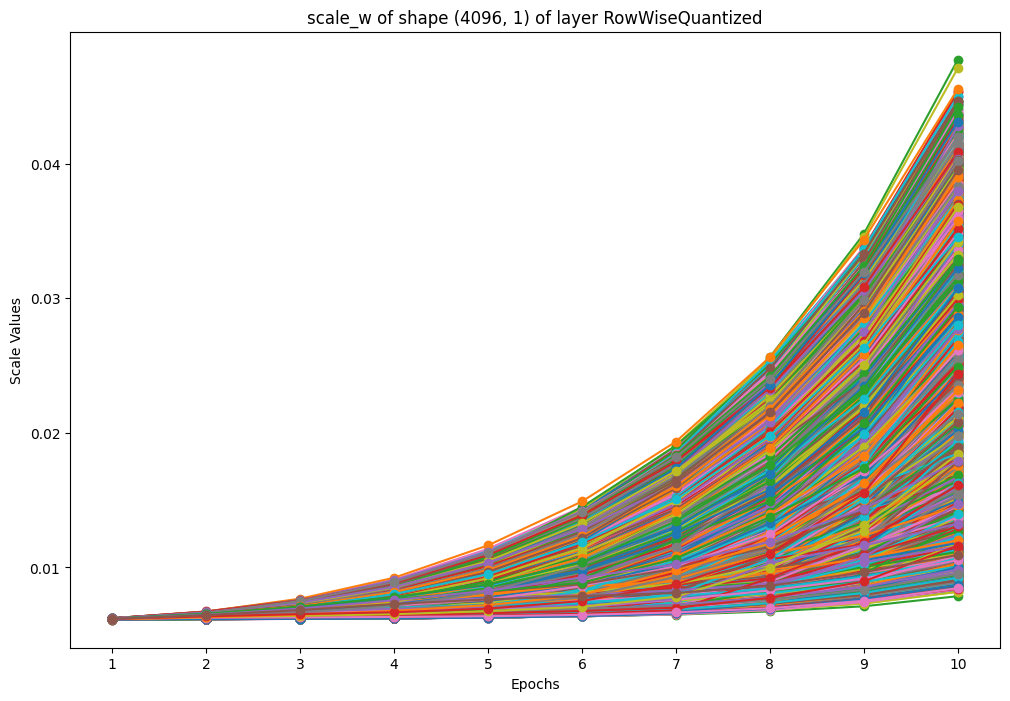

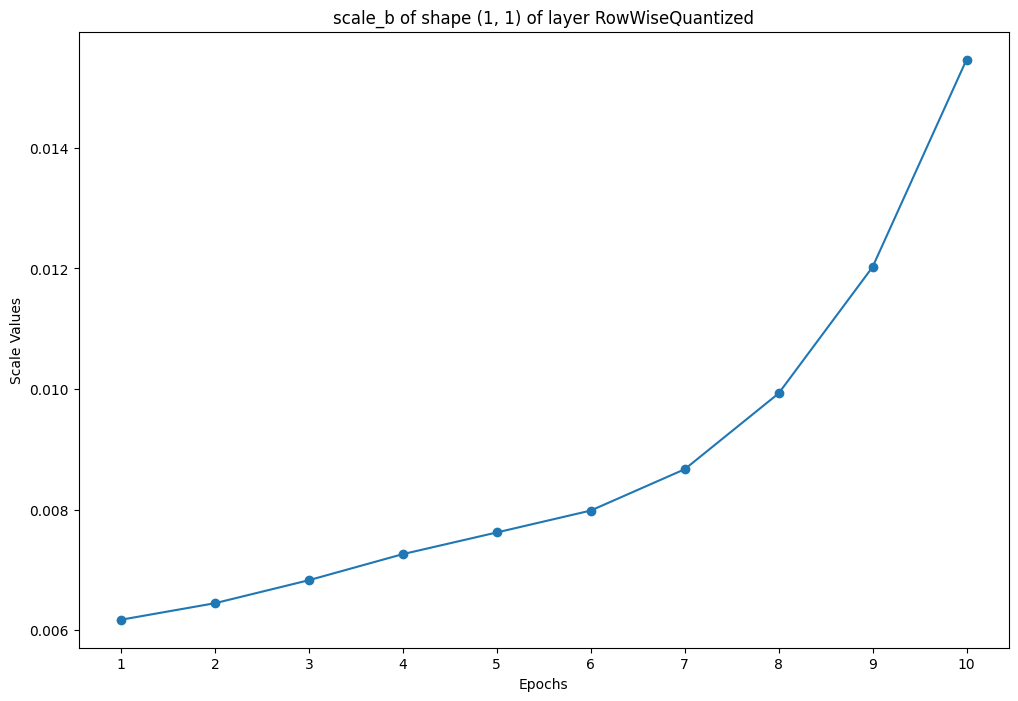

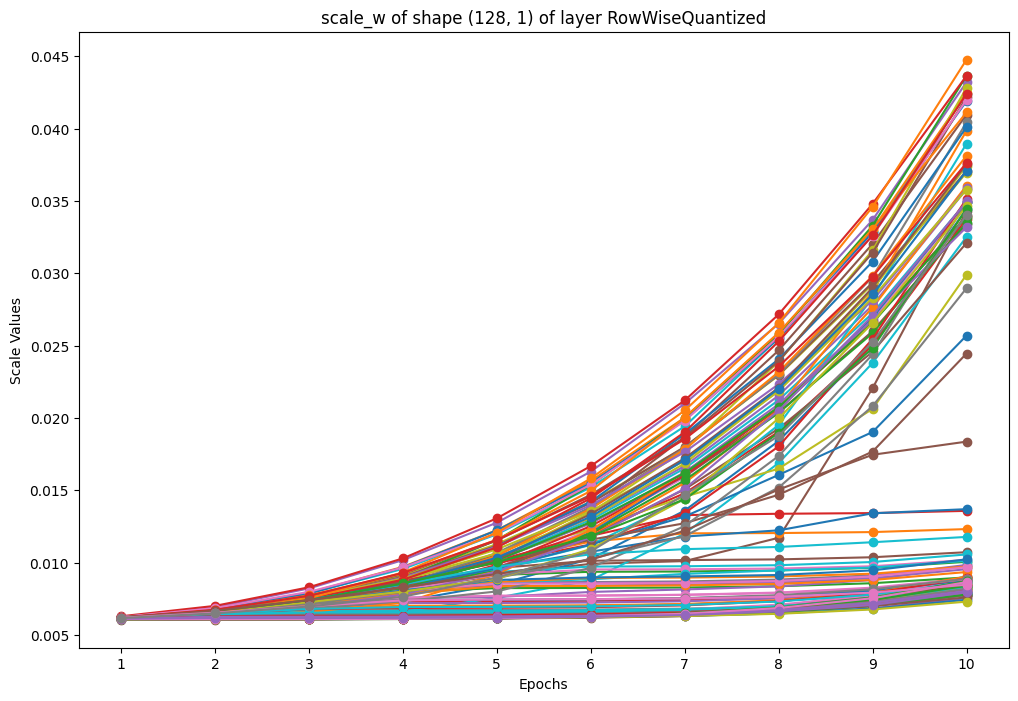

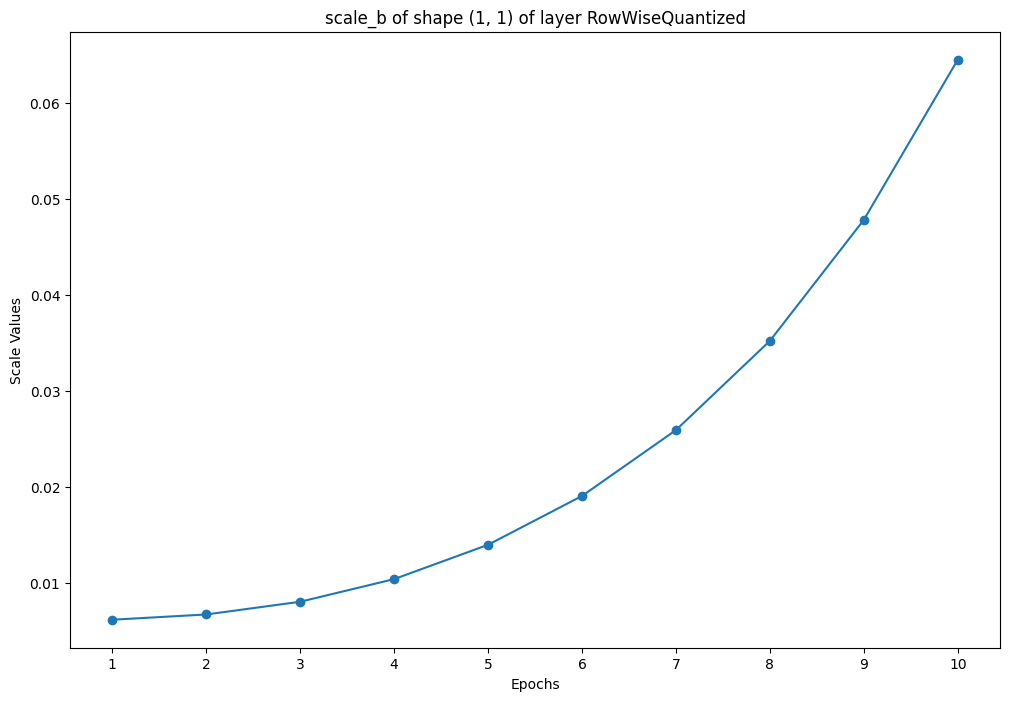

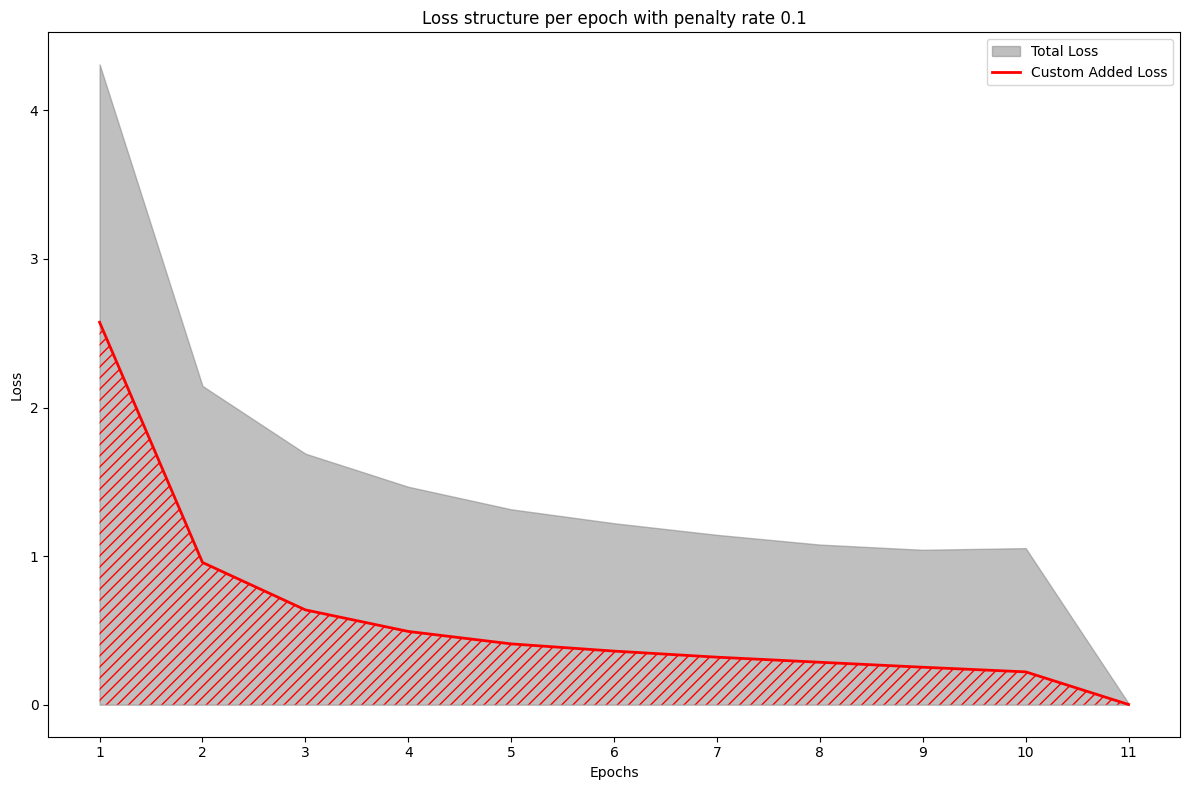

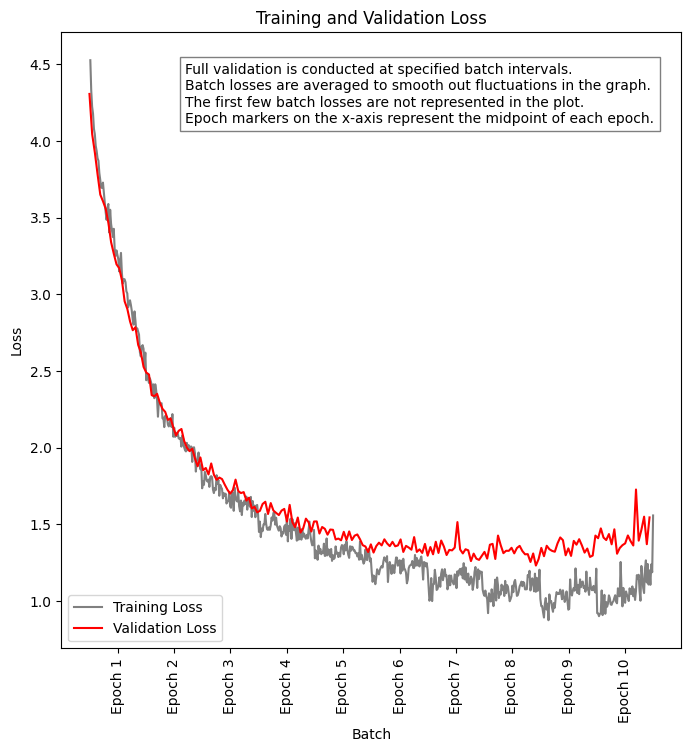

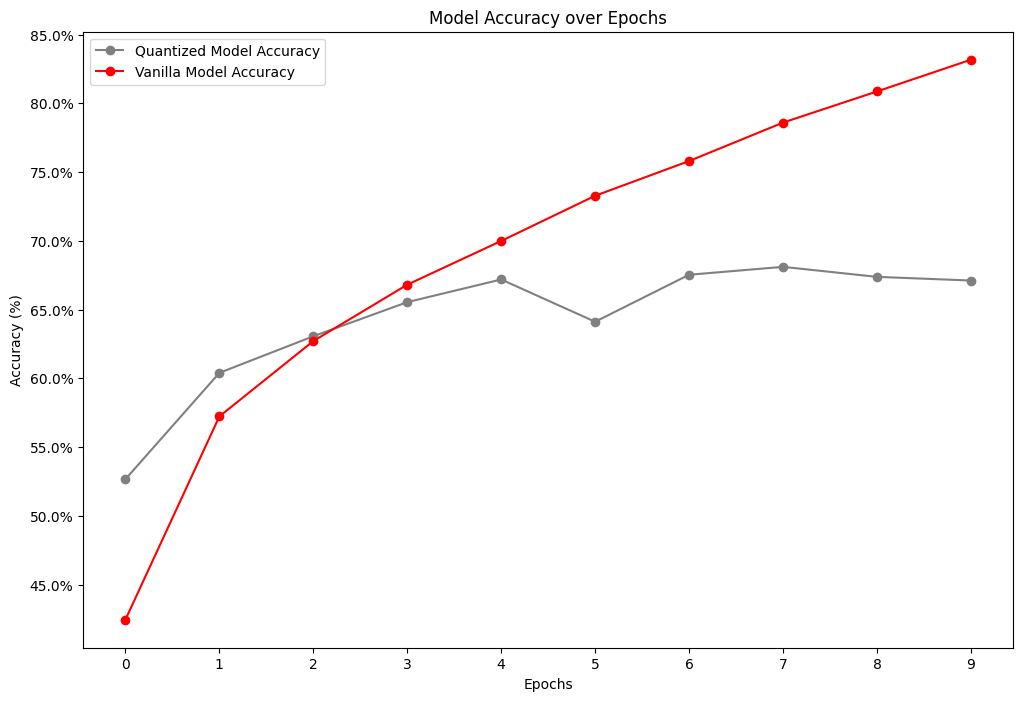

In [8]:
from plot_scripts import plot_training_validation_loss, plot_scale_values, plot_loss, plot_accuracy

# Plot scale values of first dense layer
plot_scale_values(cifar_model.get_layer(index=6), log_dir)
plot_scale_values(cifar_model.get_layer(index=8), log_dir)
plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=penalty_rate)
plot_training_validation_loss(log_dir, interval=val_interval, epochs=num_epochs, x_train_size=len(x_train), batch_size=batch_size)
plot_accuracy(log_dir)
